# Exercises - GEO4902-02 - Data Assimilation

Kjerssti Stangeland, Fall 2024

# Exercise 02-03 -  Single observation data assimilation experiment

For (a) testing new observations, (b) analyzing their impact, and (c) understanding the impact of the data assimilation system we often perform so-called “single-observation experiments”. Only one single observation is included in the data assimilation system and we can compare the background and the analysis. In the following example, a radiosonde temperature observation at 500 hPa height has been assimilated.  

The background xB and analysis xA include the prognostic variables of temperature, wind, and specific humidity. The data files are for the Norwegian area and distributed in 60 vertical levels. The python script for this exercise gives you the access points to this data and two plotting routines, in order to plot vertical sections and horizontal layers of the model data.

In [103]:
# import python packages
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import cartopy as cy
import cmocean.cm as cmo

#### Load BACKGROUND fields of temperature,wind, and specific humidity

In [104]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.BG.nc'
model_background = xr.open_dataset(url)

#### Load ANALYSIS fields of temperature,wind, and specific humidity
#### This analysis has been produced by assimilating a radiosonde information at 500hPa

In [105]:
url='https://thredds.met.no/thredds/dodsC/metusers/maltem/GEO4902_2020/remap.varn.LPB_POS2_TEMP500.nc'
model_analysis = xr.open_dataset(url)

The data is stored in the original coordinates of the model, but do not worry about that. Just assume it is some kind of vertical discretization. Remember that you can look in the metadata to find the variable names and coordinate information! 

### Below are two plotting routines which yo can use to plot horizontal and vertical sections of the model. 

In [106]:
timestep=0; modellevel=60
temp_background = model_background['air_temperature'].isel(time=timestep).sel(lev_2=modellevel)
temp_analysis   = model_analysis['air_temperature'].isel(time=timestep).sel(lev=modellevel)

diff_temp = temp_background - temp_analysis

# Task 1: Find out where the radiosonde was assimilated. (level and geographical location)

Text(0.5, 1.0, 'xB - xA for temperature, model level: 60')

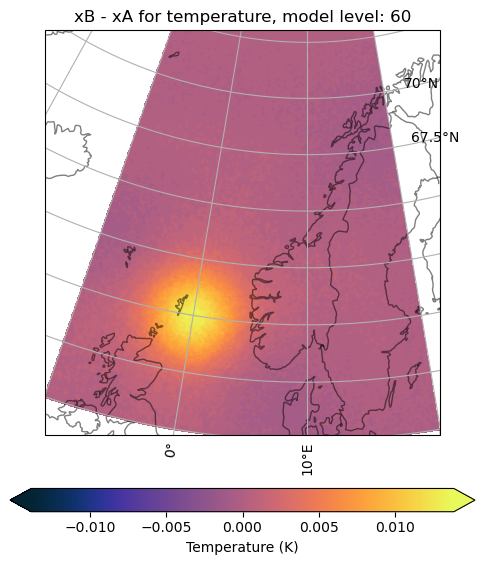

In [107]:
projection = cy.crs.Stereographic(central_latitude=78.4, central_longitude=10.0, )
f, ax = plt.subplots(1,1, subplot_kw={'projection':projection}, figsize=[10, 7])
ax.set_extent([-10, 20, 55, 72], cy.crs.PlateCarree())
ax.add_feature(cy.feature.COASTLINE, alpha=0.5)
ax.add_feature(cy.feature.BORDERS, alpha=0.5)
gl = ax.gridlines(draw_labels=True)
gl.top_labels=False
gl.right_labels=False

diff_temp.plot(ax=ax, x='lon', y='lat', cmap=cmo.thermal, extend='both', transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.6, 'pad':0.1})
ax.set_title(f'xB - xA for temperature, model level: {modellevel}')

Above we see the difference between baxckground and analysis plotted very simple. The geographic location of the data assimilation seems to be around 70 N and 0 E, right outside Shetland isles. Now we want to find at which levels the assimilation is done, we can do this by looking at a vertical cross section in that area and analyze the difference between the background and analysis. 

The difference is zero in most parts of the domain, but has a clear spike off the west coast of Norway. It is clear that this is the region where the single observation has been assimilated and therefore impacted the analysis. The difference however is not large, 0.01. 

In [74]:
timestep=0; seclat=70; # Intersection at latitude model_analysis.lat[seclat]

tempvert_background = model_background['air_temperature'].isel(time=timestep, lat=seclat)
tempvert_analysis   = model_analysis['air_temperature'].isel(time=timestep, lat=seclat)

windvert_background =(np.sqrt(model_background['x_wind']**2 + model_background['y_wind']**2)).isel(time=timestep, lat=seclat)
windvert_analysis   =(np.sqrt(model_analysis['x_wind']**2 + model_analysis['y_wind']**2)).isel(time=timestep, lat=seclat)

humidvert_background = model_background['specific_humidity'].isel(time=timestep, lat=seclat)
humidvert_analysis   = model_analysis['specific_humidity'].isel(time=timestep, lat=seclat)

In [92]:
diff_vert_temp = tempvert_background.values - tempvert_analysis.values
diff_vert_wind = windvert_background.values - windvert_analysis.values
diff_humidvert = humidvert_background.values - humidvert_analysis.values

Text(0.5, 1.0, 'Specific Humidity difference, xB-xA')

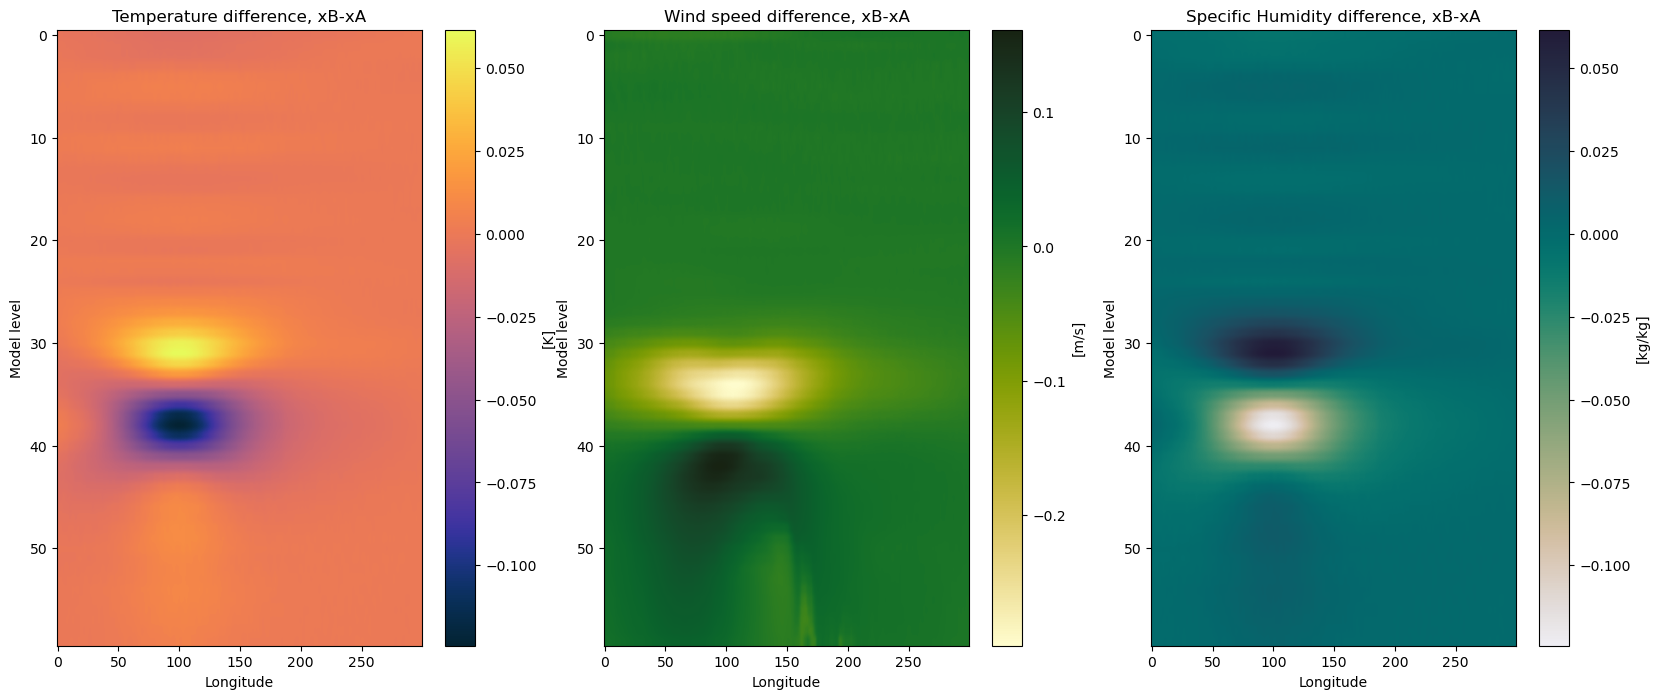

In [97]:
f, ax = plt.subplots(1,3,figsize=[20, 8])

im = ax[0].imshow(diff_vert_temp, aspect='auto', cmap=cmo.thermal)
cbar = plt.colorbar(im, ax=ax[0], label='[K]')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Model level')
ax[0].set_title('Temperature difference, xB-xA')

im0 = ax[1].imshow(diff_vert_wind, aspect='auto', cmap=cmo.speed)
cbar = plt.colorbar(im0, ax=ax[1], label='[m/s]')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Model level')
ax[1].set_title('Wind speed difference, xB-xA')

im1 = ax[2].imshow(diff_vert_temp, aspect='auto', cmap=cmo.rain)
cbar = plt.colorbar(im1, ax=ax[2], label='[kg/kg]')
ax[2].set_xlabel('Longitude')
ax[2].set_ylabel('Model level')
ax[2].set_title('Specific Humidity difference, xB-xA')



The plots above agree well on that the largest difference between the background and analysis is happening around model levels 30-40 around the 100 E.

So to summarize: the plots indicate that the radiosonde was assimilated at model levels 30-40 outside Shetland isles, around 60N, 100E. (which doesn really makes sense cause 60N/100E is in Russia and is outside the model domain?? Why is the longitude weird, or am I weird??) The spot showed up at 0 E in the previous plot..

# Task 2: Estimate the spatial impact this one observation has.   

In [100]:
timestep=0; modellevel=35
temp_background = model_background['air_temperature'].isel(time=timestep).sel(lev_2=modellevel)
temp_analysis   = model_analysis['air_temperature'].isel(time=timestep).sel(lev=modellevel)

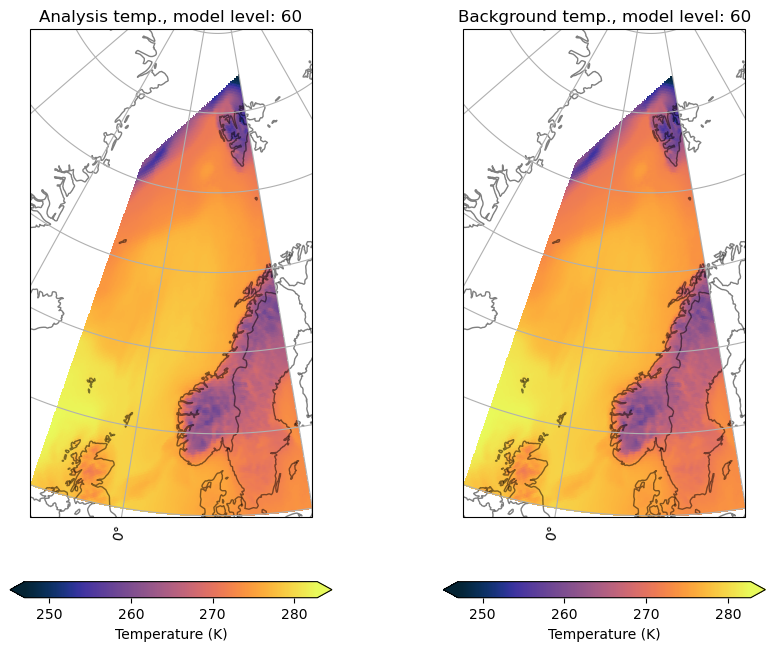

In [118]:
projection = cy.crs.Stereographic(central_latitude=78.4, central_longitude=10.0, )
fig, ax = plt.subplots(1,2, subplot_kw={'projection':projection}, figsize=[10, 7])

for axs in ax: 
    axs.add_feature(cy.feature.COASTLINE, alpha=0.5)
    axs.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = axs.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False

temp_analysis.plot(ax=ax[0], x='lon', y='lat', cmap=cmo.thermal, extend='both', transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.6, 'pad':0.1})
ax[0].set_title(f'Analysis temp., model level: {modellevel}')

temp_background.plot(ax=ax[1], x='lon', y='lat', cmap=cmo.thermal, extend='both', transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Temperature (K)', 'shrink':0.6, 'pad':0.1})
ax[1].set_title(f'Background temp., model level: {modellevel}')

fig.tight_layout()

I´m not fully sure how to estimate the spatial impact that the observation had. The two maps above show the analysis and the background, and the difference is not very visible. In the map which shows the analysis - background shows maybe more the spatial impact, as the single observation with a radiosonde is on one location wheras the impact is a small sphere around it. 

# Task 3: - What is the impact on wind and humidity, and why&how could that be realized in the data assimilation system?

Changes in the air temperature may affect other atmospheric variables such as wind and humidity, as these are correlated. To see the impact, I will again plot the difference between background and analysis for wind and humidity. The data assimilation system will adjust other variables related to the temperature to fulfill physical equations, and hence will observations of tempeature which are included in the data assimilation alter other variables. 

In [121]:
# Wind
timestep=0; modellevel=60
x_wind_background = model_background['x_wind'].isel(time=timestep).sel(lev_2=modellevel)
y_wind_background = model_background['y_wind'].isel(time=timestep).sel(lev_2=modellevel)

wind_background = np.sqrt(x_wind_background**2 + y_wind_background**2)

x_wind_analysis = model_analysis['x_wind'].isel(time=timestep).sel(lev=modellevel)
y_wind_analysis = model_analysis['y_wind'].isel(time=timestep).sel(lev=modellevel)

wind_analysis = np.sqrt(x_wind_analysis**2 + y_wind_analysis**2)

diff_wind = wind_background - wind_analysis

In [122]:
# Humidity 

humidity_background = model_background['specific_humidity'].isel(time=timestep).sel(lev_2=modellevel)
humidity_analysis = model_analysis['specific_humidity'].isel(time=timestep).sel(lev=modellevel)

diff_humidity = humidity_background - humidity_analysis

Text(0.5, 1.0, 'xB - xA for specific humidity, model level: 60')

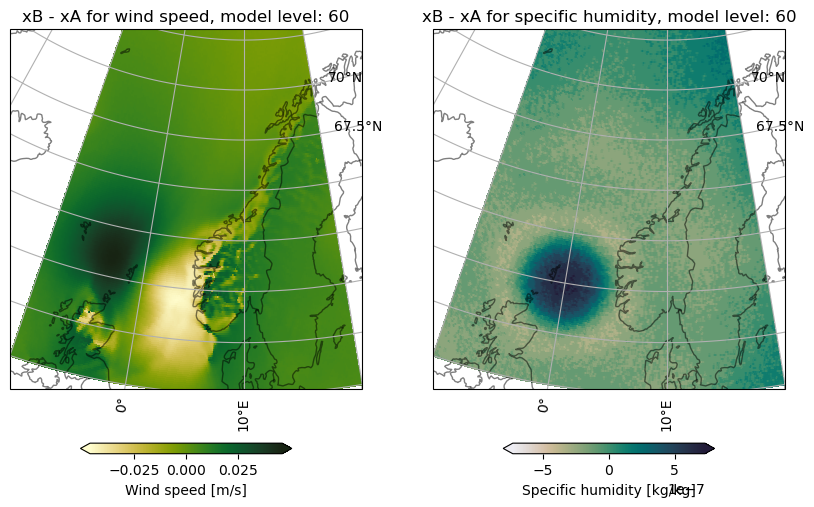

In [124]:
projection = cy.crs.Stereographic(central_latitude=78.4, central_longitude=10.0, )
f, ax = plt.subplots(1,2, subplot_kw={'projection':projection}, figsize=[10, 7])

for axs in ax:
    axs.set_extent([-10, 20, 55, 72], cy.crs.PlateCarree())
    axs.add_feature(cy.feature.COASTLINE, alpha=0.5)
    axs.add_feature(cy.feature.BORDERS, alpha=0.5)
    gl = axs.gridlines(draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False

diff_wind.plot(ax=ax[0], x='lon', y='lat', cmap=cmo.speed, extend='both', transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Wind speed [m/s]', 'shrink':0.6, 'pad':0.1})
ax[0].set_title(f'xB - xA for wind speed, model level: {modellevel}')

diff_humidity.plot(ax=ax[1], x='lon', y='lat', cmap=cmo.rain, extend='both', transform=cy.crs.PlateCarree(), cbar_kwargs={'orientation':'horizontal','label':'Specific humidity [kg/kg]', 'shrink':0.6, 'pad':0.1})
ax[1].set_title(f'xB - xA for specific humidity, model level: {modellevel}')

Due to the assimilated temperature observation, both the windspeed and humidity is altered in the analysis. This is realized with a B-matrix in the data assimilation process, where the correlations between the variables are. This takes care of both the physics and the errors of both model and observations. Above we see that the largest impact of the point observation is located around the area where the data was retrieved, but that there are "ripple effects" further out. 